# 정형 데이터마이닝

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

1.&nbsp; 데이터의 요약값을 보고 NA값이 10,000개 이상인 열을 제외하고 남은 변수 중 NA값이 있는 행을 제거하시오. 그리고 AUS 데이터의 Date 변수를 Date형으로 변환하고, 전처리가 완료된 weather AUS 데이터를 train(70%), test(30%) 데이터로 분할하시오. (set.seed(6789)를 실행한 후 데이터를 분할하시오.)

In [2]:
data_path = '/hdd/data/adp_data/weatherAUS.csv'
df = pd.read_csv(data_path)
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
na_counts = df.isna().sum()
columns_to_drop = na_counts[na_counts >= 10000].index
df_cleaned = df.drop(columns = columns_to_drop)

df_cleaned = df_cleaned.dropna()

df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

2.&nbsp; train 데이터로 종속변수인 RainTomorrow(다음날을 강수 여부)를 예측하는 분류모델을 3개 이상 생성하고, test 데이터에 대한 예측값을 csv파일로 각각 제출하시오.

In [4]:
label_encoder = {}
for col in df_cleaned.select_dtypes(include = ['object']).columns:
    if col != 'RainTomorrow':
        le = LabelEncoder()
        df_cleaned[col] = le.fit_transform(df_cleaned[col])
        label_encoder[col] = le

le_target = LabelEncoder()
df_cleaned['RainTomorrow'] = le_target.fit_transform(df_cleaned['RainTomorrow'])

In [5]:
X = df_cleaned.drop(columns = ['Date', 'RainTomorrow'], axis = 1)
y = df_cleaned['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = 6723
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(90003, 14) (90003,)
(38573, 14) (38573,)


3.&nbsp; 생성된 3개의 분류모델에 대해 성과분석을 실시하여 정확도를 비교하여 설명하시오. 또, ROC curve를 그리고 AUC값을 산출하시오.

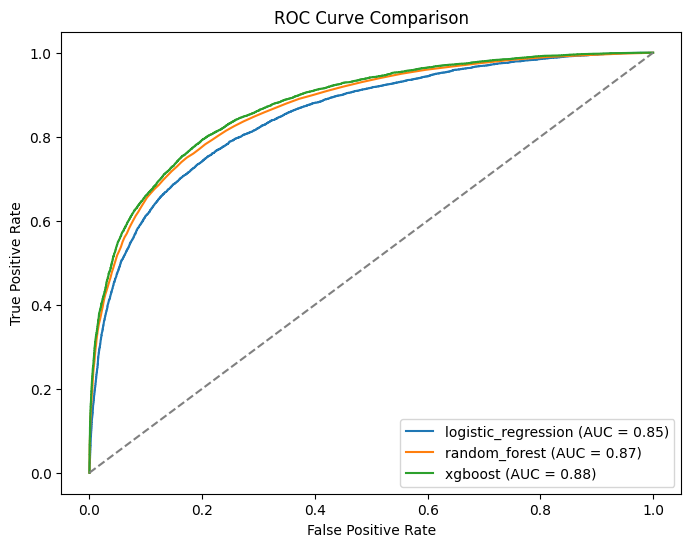

logistic_regression 정확도: 0.8473
random_forest 정확도: 0.8559
xgboost 정확도: 0.8622


In [6]:
models = {
    'logistic_regression': LogisticRegression(max_iter = 1000),
    'random_forest': RandomForestClassifier(n_estimators = 100, random_state = 6789),
    'xgboost': XGBClassifier(eval_metric = 'logloss', random_state = 6789)
}

accuracies = {}
roc_data = {}

plt.figure(figsize = (8, 6))
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc

    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    auc_value = auc(fpr, tpr)
    roc_data[name] = (fpr, tpr, auc_value)

    plt.plot(fpr, tpr, label = f'{name} (AUC = {auc_value:.2f})')

plt.plot([0, 1], [0, 1], linestyle = '--', color = 'grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

for name, acc in accuracies.items():
    print(f'{name} 정확도: {acc:.4f}')